In [17]:
import numpy as np
import itertools
import math
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import QuantumCircuit
#from qiskit import Aer

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit.providers.aer import QasmSimulator
import qiskit_aer.noise as noise

from qiskit.circuit.library import UnitaryGate

#My imports
from coolingUnitary import CoolingUnitary
from mirrorProtocol import MirrorProtocol
from pairingPartnerAlgorithm import PairingPartnerAlgorithm
from minimalWorkProtocol import MinimalWorkProtocol
from utils import *

In [2]:
def get_strings(N, bits_set):
    result = []
    for bits in itertools.combinations(range(N), bits_set):
        s = ['0'] * N
        for bit in bits:
            s[bit] = '1'
        result.append(''.join(s))
    return result

def append_one(strings):
    result = []
    for string in strings:
        result.append(string + '1')
    return result

def get_complement(string):
    complement = ''
    for bit in string:
        if (bit == '1'):
            complement += '0'
        else:
            complement += '1'
    return complement

def bin_string_to_int(string):
    return int(string,2)

#generate cooling unitary Uc
def generate_Uc(n):
    #number of cooling qubits
    N = n-1
    #initialize cooling unitary
    dim = 2**n
    Uc = np.eye(dim,dim)
    #loop over excitation sectors to pair
    for i in range(0,math.floor(N/2)):
        #total number of excitations in n=N+1 bits is i+1
        #we assume last bit is set to 1, so we want all permutations of i bits set in the first N bits
        bits_set = i
        #get all strings of length N with bits_set bits set to 1
        strings = get_strings(N,bits_set)
        #add '1' to end of all strings
        full_strings = append_one(strings)
        #set appropriate entries in Uc to 1 to implement SWAP between complementary states
        for string in full_strings:
            idx1 = bin_string_to_int(string)
            idx2 = bin_string_to_int(get_complement(string))
            Uc[idx1,idx2] = 1
            Uc[idx2,idx1] = 1
            Uc[idx1,idx1] = 0
            Uc[idx2,idx2] = 0
    return Uc

In [3]:
u = generate_Uc(3)
u

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [4]:
checkUnitary(u)

0 | 000 --> 000
1 | 001 --> 110 (*)
2 | 010 --> 010
3 | 011 --> 011
-------------------------
4 | 100 --> 100
5 | 101 --> 101
6 | 110 --> 001 (*)
7 | 111 --> 111


In [5]:
a = MinimalWorkProtocol(3,0.01)
a

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [6]:
checkUnitary(a)

0 | 000 --> 000
1 | 001 --> 001
2 | 010 --> 010
3 | 011 --> 100 (*)
-------------------------
4 | 100 --> 011 (*)
5 | 101 --> 101
6 | 110 --> 110
7 | 111 --> 111


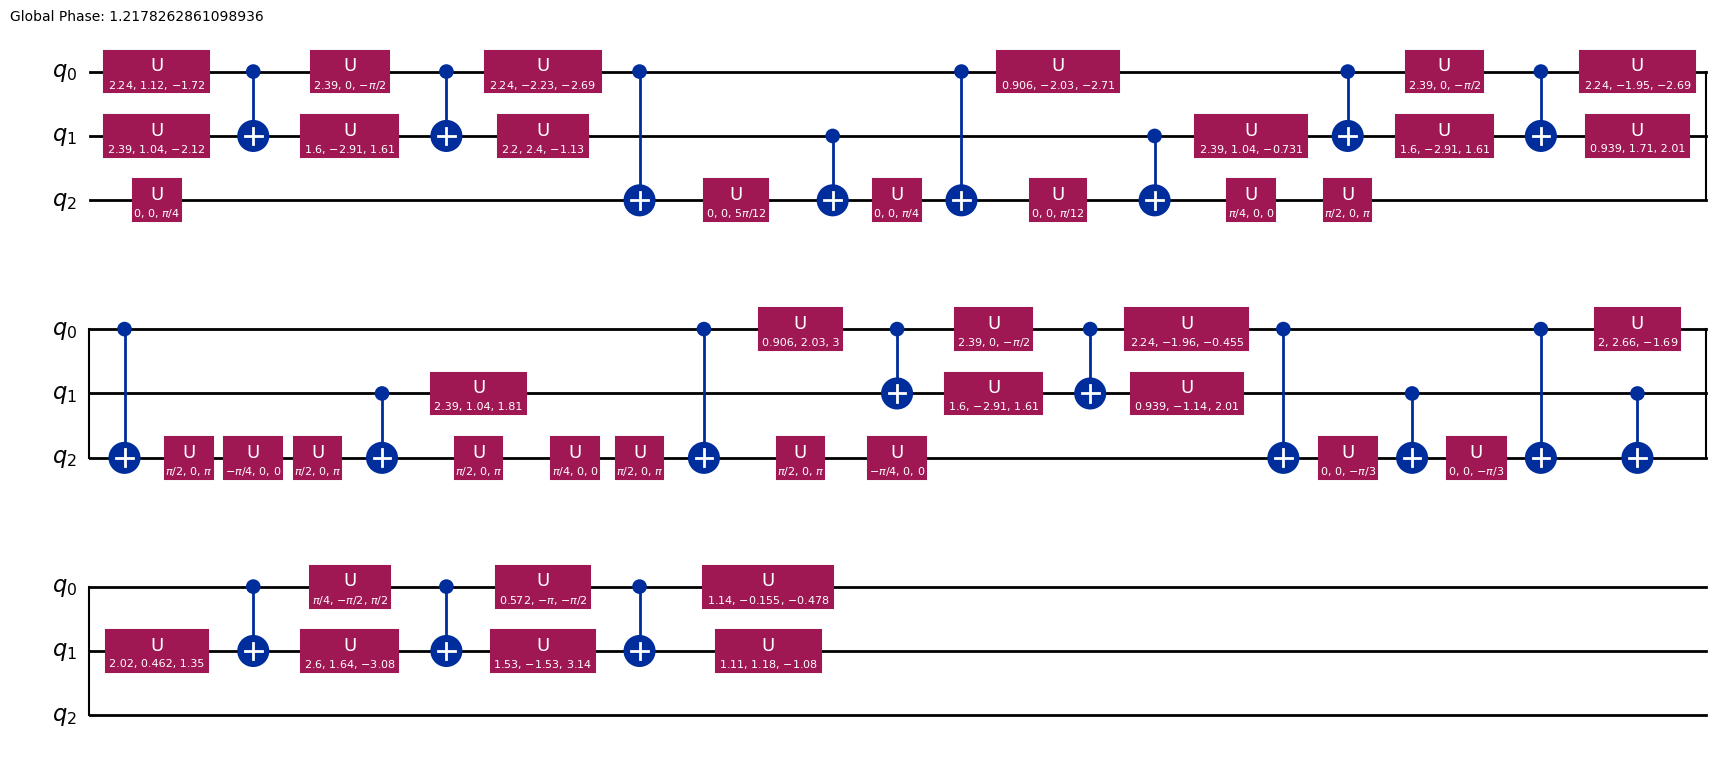

In [13]:
n = 3
cooling_circuit = QuantumCircuit(n)
cooling_circuit.unitary(a, range(n))
cooling_circuit.draw("mpl")
cooling_circuit.decompose().decompose().draw("mpl")

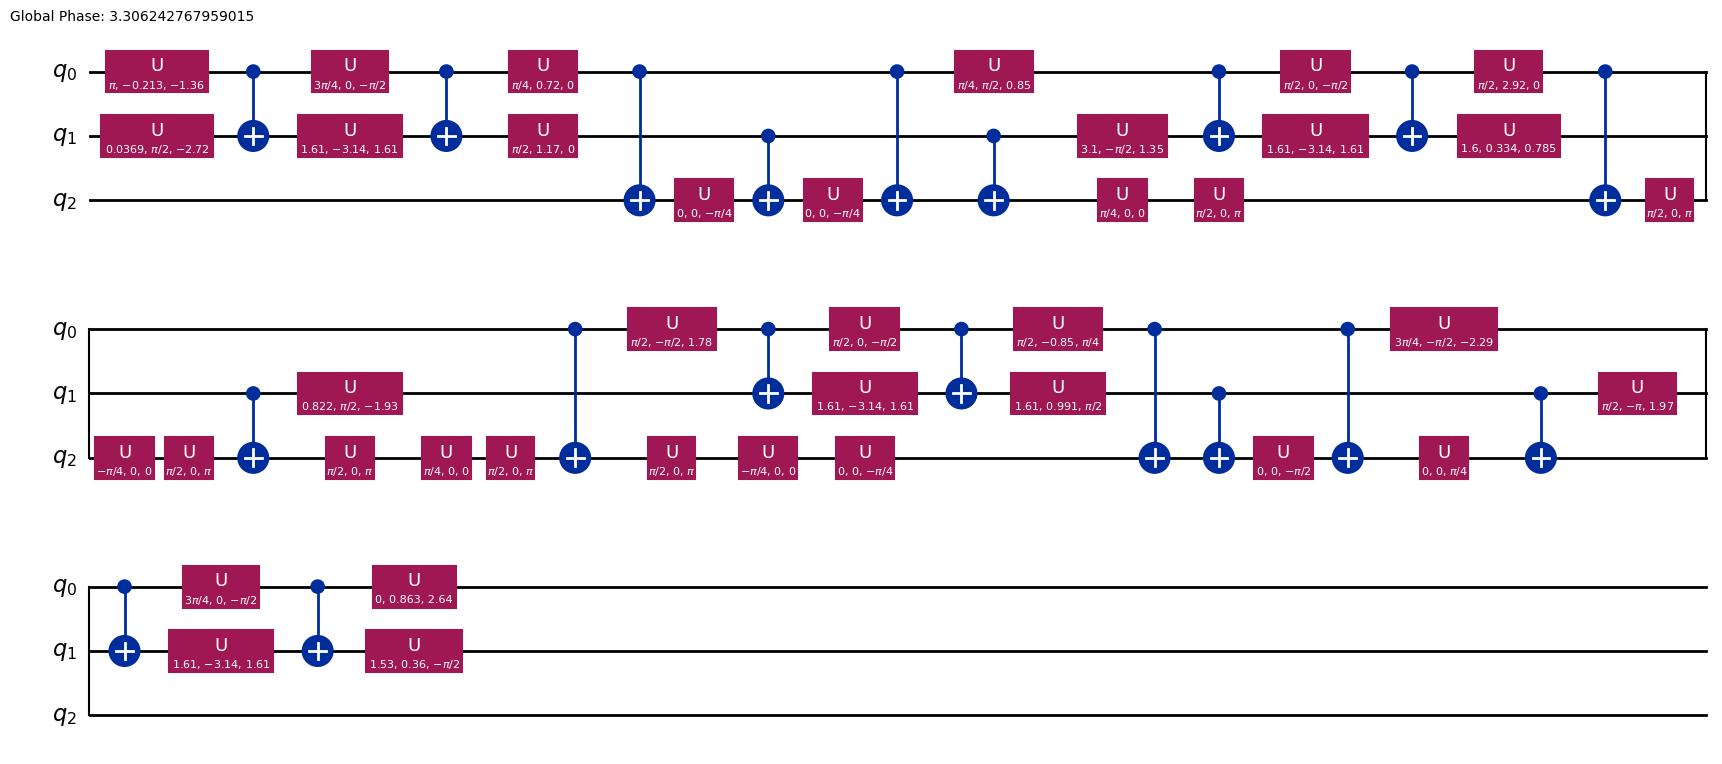

In [12]:
u = generate_Uc(3)
cooling_circuit2 = QuantumCircuit(n)
cooling_circuit2.unitary(u, range(n))

cooling_circuit2.draw("mpl")
cooling_circuit2.decompose().decompose().draw("mpl")

In [20]:
#provider = QiskitRuntimeService()
service = QiskitRuntimeService()
sim_backend = service.backend("ibmq_qasm_simulator")
qasm_sim = AerSimulator()

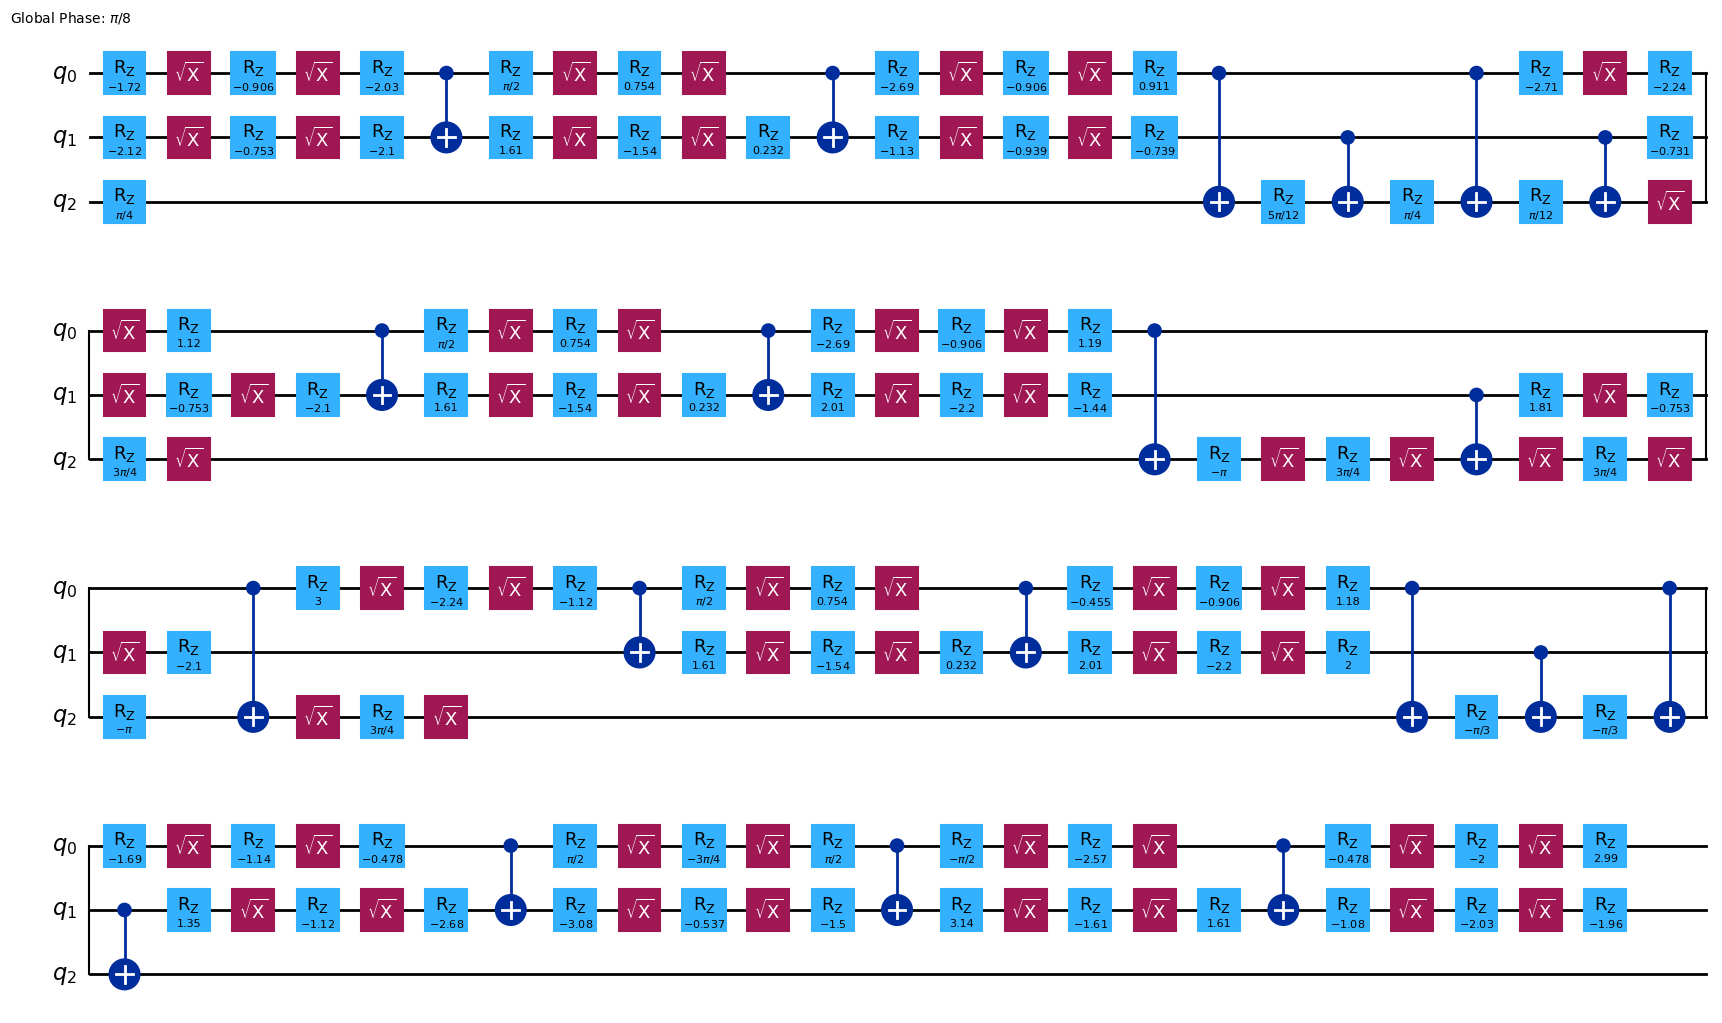

In [22]:
n = 3
cooling_circuit = QuantumCircuit(n)
cooling_circuit.append(UnitaryGate(a),range(n))
cooling_circuit.draw("mpl")
#cooling_circuit.decompose().decompose().draw("mpl")
traspiled = qk.transpile(cooling_circuit, backend=sim_backend)
traspiled.draw("mpl")

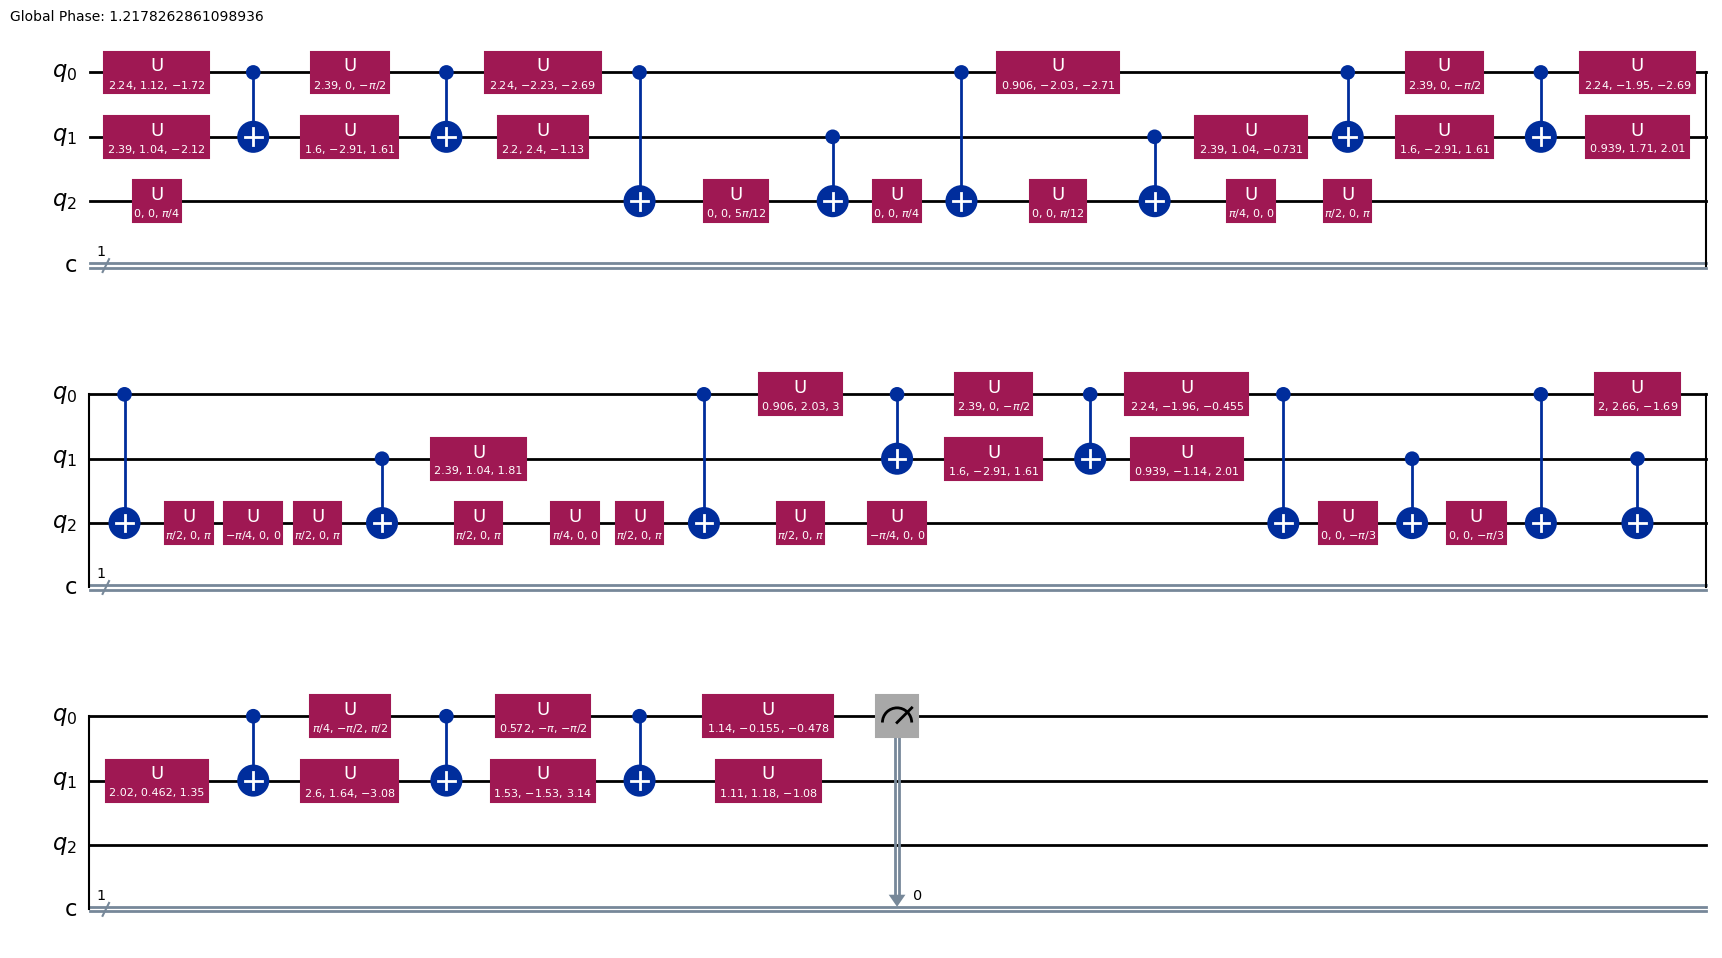

In [23]:

#cooling_circuit.unitary(a, range(n))
num_circs = 2**n
circuits = []
q_regs = qk.QuantumRegister(n, 'q')
c_regs = qk.ClassicalRegister(1, 'c')
#make circuits
for i in range(num_circs):
    total_circ = qk.QuantumCircuit(q_regs, c_regs)
    #prepare initial state
    bitstring = format(i,'b').zfill(n)
    idx = 0
    for bit in bitstring:
        if (bit == '1'):
            total_circ.x(idx)
        idx += 1
    #add cooling circuits
    total_circ.compose(cooling_circuit, qubits=[q_regs[0],q_regs[1],q_regs[2]], inplace=True)
    #add measurement
    total_circ.measure(0, c_regs)
    circuits.append(total_circ)

circuits[0].decompose().decompose().draw("mpl")

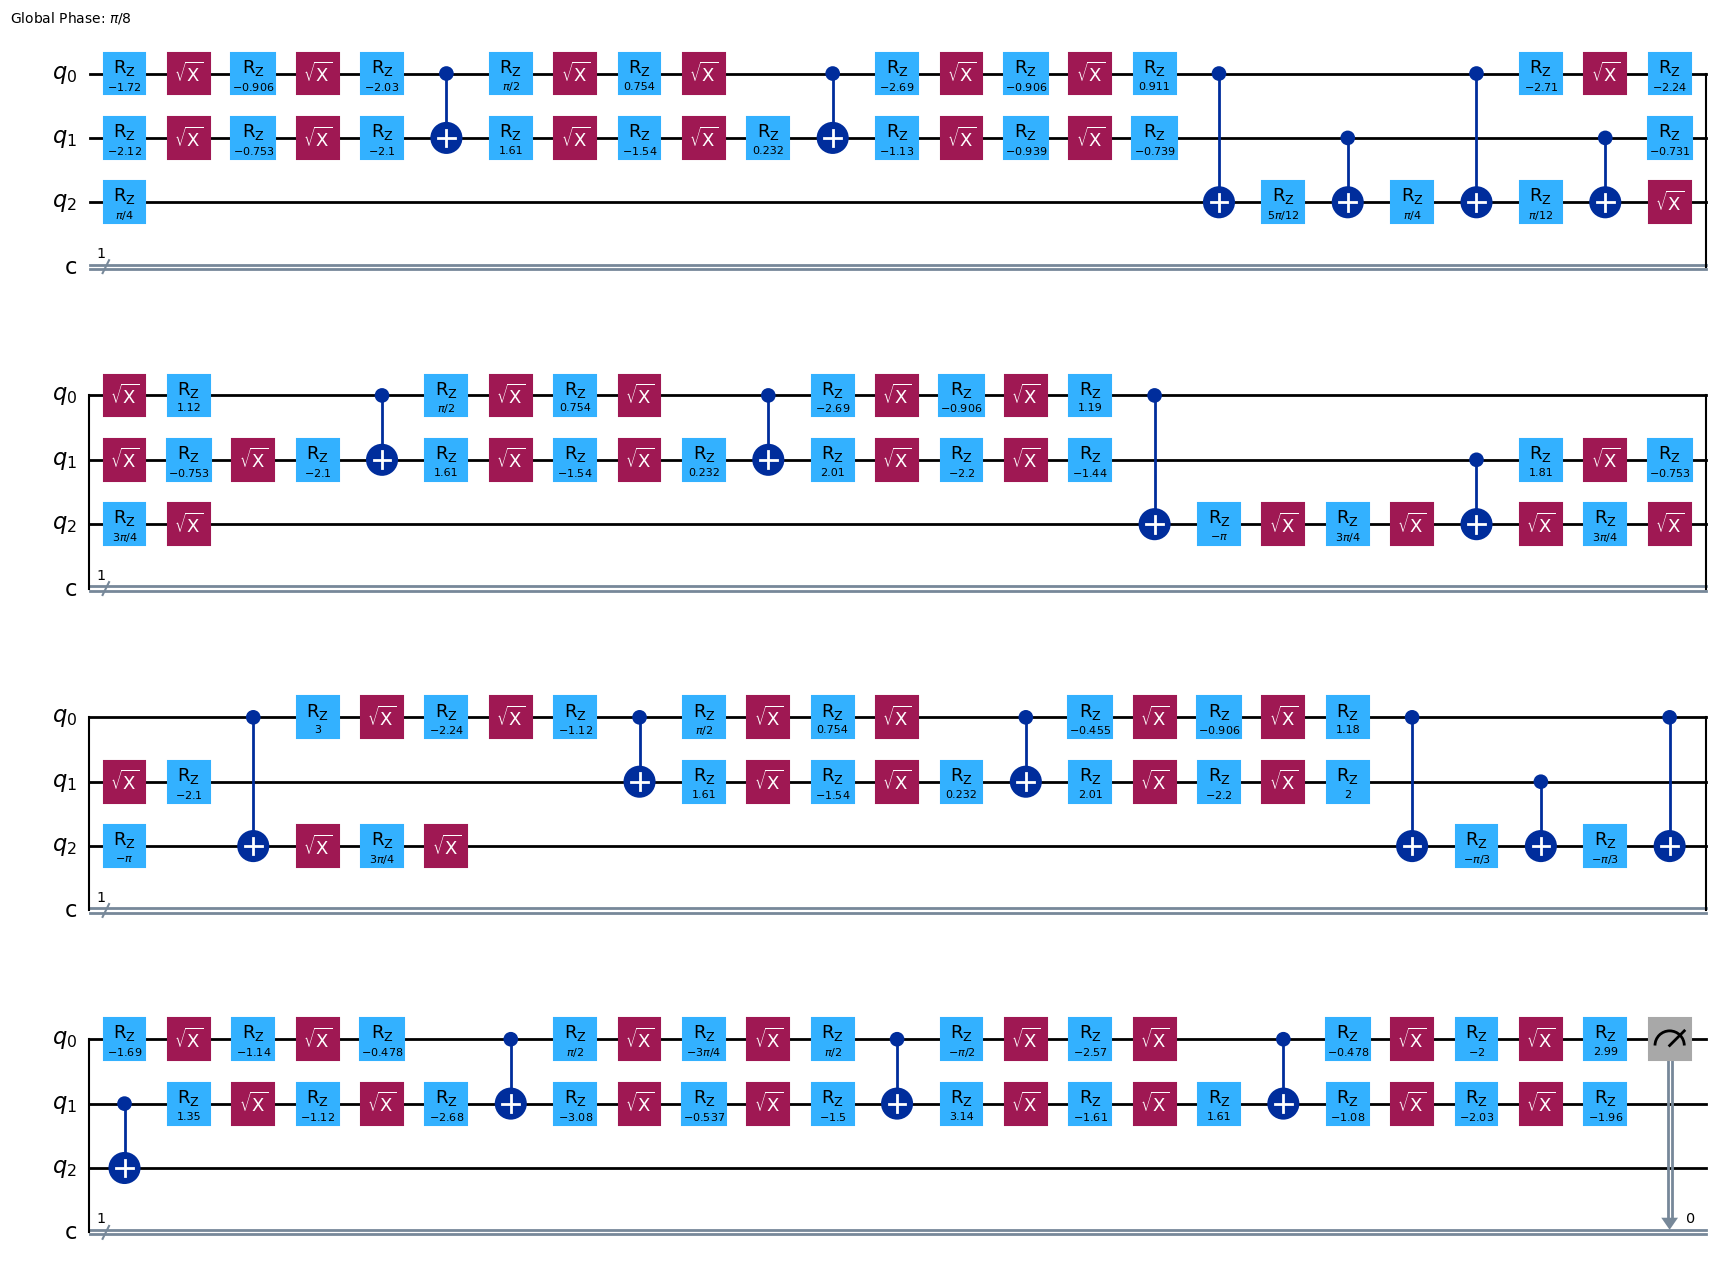

In [24]:
traspiled = qk.transpile(circuits[0], backend=sim_backend)
traspiled.draw("mpl")